In [ ]:
# Read readme.md from github
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/Challenge_1/"

Mounted at /gdrive
/gdrive/My Drive/Challenge_1


## Import Python packages

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["MPLCONFIGDIR"] = os.getcwd() + "/configs/"

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

import numpy as np

np.random.seed(seed)

import logging

import random

random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
import seaborn as sns

2.14.0


In [ ]:
from tensorflow.keras.applications import densenet

In [ ]:
IMG_SIZE = 224

## Import dataset

In [ ]:
dataset = np.load('new_dataset.npz', allow_pickle=True) #If you are running it using Colab
images = dataset['data']
labels = dataset['labels']

In [ ]:
# Extract classes separately
healthy_labels = np.where(labels == "healthy")[0]
unhealthy_labels = np.where(labels == "unhealthy")[0]

healthy_images = images[healthy_labels]
unhealthy_images = images[unhealthy_labels]

### Split dataset

In [ ]:
X = np.concatenate([healthy_images, unhealthy_images], axis=0)
y = np.concatenate([np.zeros(len(healthy_images)), np.ones(len(unhealthy_images))], axis=0)

In [ ]:
# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, random_state=seed, test_size=0.25, stratify=y
)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    random_state=seed,
    test_size=len(X_test),
    stratify=y_train_val,
)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (2266, 96, 96, 3), y_train shape: (2266,)
X_val shape: (1133, 96, 96, 3), y_val shape: (1133,)
X_test shape: (1133, 96, 96, 3), y_test shape: (1133,)


### preproces input - Mobile net


In [ ]:
def proc_input(X_input):
    X_input = tfkl.Resizing(IMG_SIZE, IMG_SIZE)(X_input)
    X_input = tf.cast(X_input, tf.float32)
    X_input = tf.keras.applications.densenet.preprocess_input(X_input)
    return X_input

X_train = proc_input(X_train)
X_val = proc_input(X_val)
# X_test = proc_input(X_test)  ## See last function


In [ ]:
X_train.shape

TensorShape([2266, 224, 224, 3])

In [ ]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = 1
batch_size = 32
epochs = 30

# Print input shape, batch size, and number of epochs
print(
    f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}"
)

Input Shape: (224, 224, 3), Output Shape: 1, Batch Size: 32, Epochs: 30


### Callbacks

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

calbacks = [reduce_lr, early_stopping]

In [ ]:
img_augmentation = tfk.Sequential(
    [
        tfk.layers.RandomRotation(factor=0.15),
        tfk.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tfk.layers.RandomFlip(),
        tfk.layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

## Build model - frozen

In [ ]:
from keras.src.applications import DenseNet169
def build_model(num_classes):
    inputs = tfk.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = DenseNet169(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False


    # Rebuild top
    top_dropout_rate = 0.2
    x = tfk.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tfk.layers.BatchNormalization()(x)

    # Create new top

    x = tfk.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = tfk.layers.Dense(num_classes, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="DenseNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

    loss = tf.keras.losses.BinaryCrossentropy()
    metrics = ["accuracy"]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [ ]:
model = build_model(num_classes=1)
model.summary()

epochs = 30  # @param {type: "slider", min:8, max:80}
hist = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=calbacks,
    verbose=1,
).history

51877672/51877672 [==============================] - 0s 0us/step
Model: "DenseNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 img_augmentation (Sequenti  (None, 224, 224, 3)          0         ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['img_augmentation[0][0]']    
 g2D)                                                                                             
                          

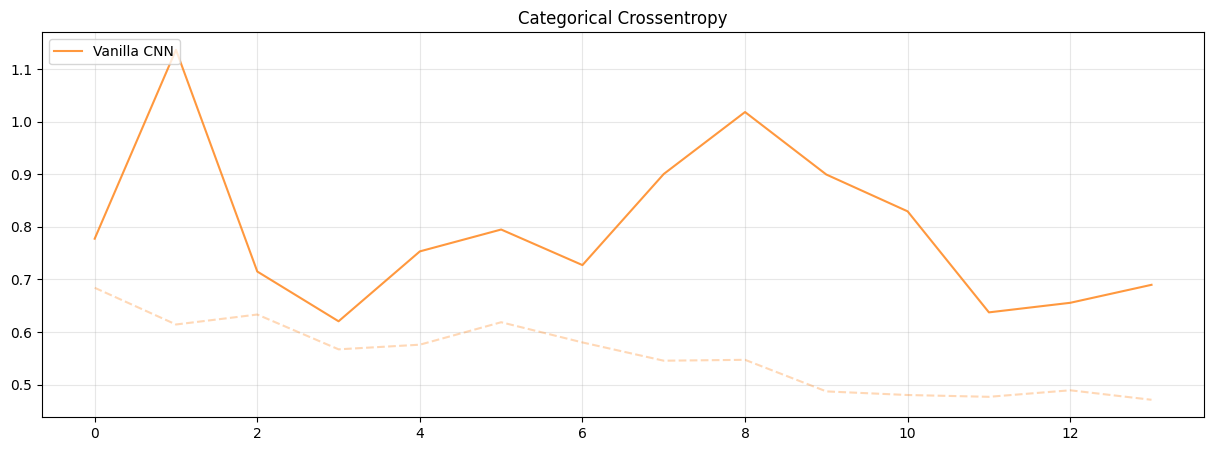

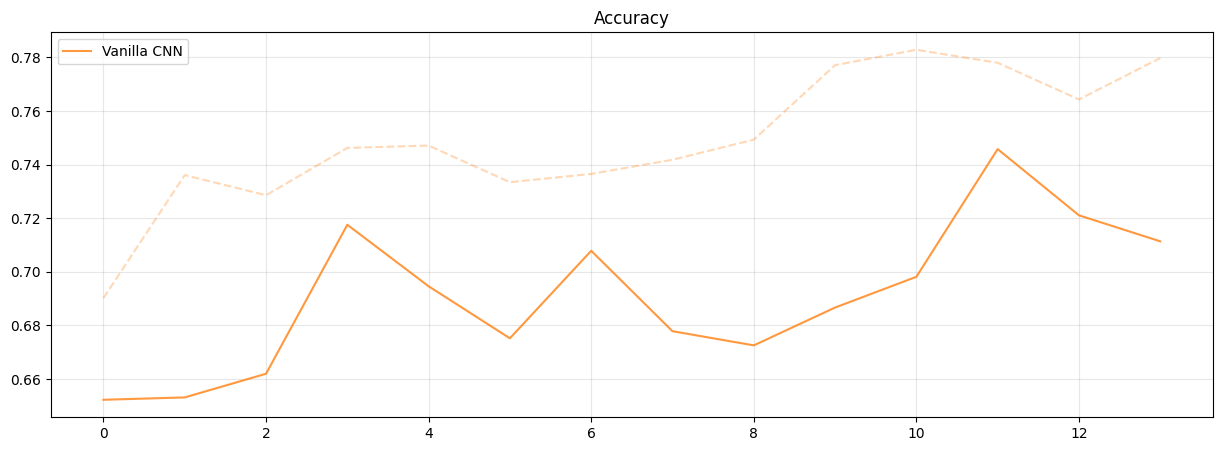

In [ ]:
# Plot the training
plt.figure(figsize=(15, 5))
plt.plot(hist["loss"], alpha=0.3, color="#ff7f0e", linestyle="--")
plt.plot(hist["val_loss"], label="Vanilla CNN", alpha=0.8, color="#ff7f0e")
plt.legend(loc="upper left")
plt.title("Categorical Crossentropy")
plt.grid(alpha=0.3)

plt.figure(figsize=(15, 5))
plt.plot(hist["accuracy"], alpha=0.3, color="#ff7f0e", linestyle="--")
plt.plot(hist["val_accuracy"], label="Vanilla CNN", alpha=0.8, color="#ff7f0e")
plt.legend(loc="upper left")
plt.title("Accuracy")
plt.grid(alpha=0.3)

plt.show()

## Build model - unfrozen

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, tfk.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 30  # @param {type: "slider", min:8, max:50}
hist2 = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=calbacks,
    verbose=1,
).history

Epoch 1/30
71/71 [==============================] - 30s 242ms/step - loss: 0.0000e+00 - accuracy: 0.7868 - val_loss: 0.0000e+00 - val_accuracy: 0.6628 - lr: 1.0000e-04
Epoch 2/30
71/71 [==============================] - 15s 208ms/step - loss: 0.0000e+00 - accuracy: 0.7992 - val_loss: 0.0000e+00 - val_accuracy: 0.6611 - lr: 1.0000e-04
Epoch 3/30
71/71 [==============================] - 15s 207ms/step - loss: 0.0000e+00 - accuracy: 0.7851 - val_loss: 0.0000e+00 - val_accuracy: 0.6778 - lr: 1.0000e-04
Epoch 4/30
71/71 [==============================] - 14s 205ms/step - loss: 0.0000e+00 - accuracy: 0.7727 - val_loss: 0.0000e+00 - val_accuracy: 0.6734 - lr: 1.0000e-04
Epoch 5/30
71/71 [==============================] - 13s 189ms/step - loss: 0.0000e+00 - accuracy: 0.7440 - val_loss: 0.0000e+00 - val_accuracy: 0.6531 - lr: 1.0000e-04
Epoch 6/30
71/71 [==============================] - 14s 202ms/step - loss: 0.0000e+00 - accuracy: 0.7255 - val_loss: 0.0000e+00 - val_accuracy: 0.6717 - lr: 1.0

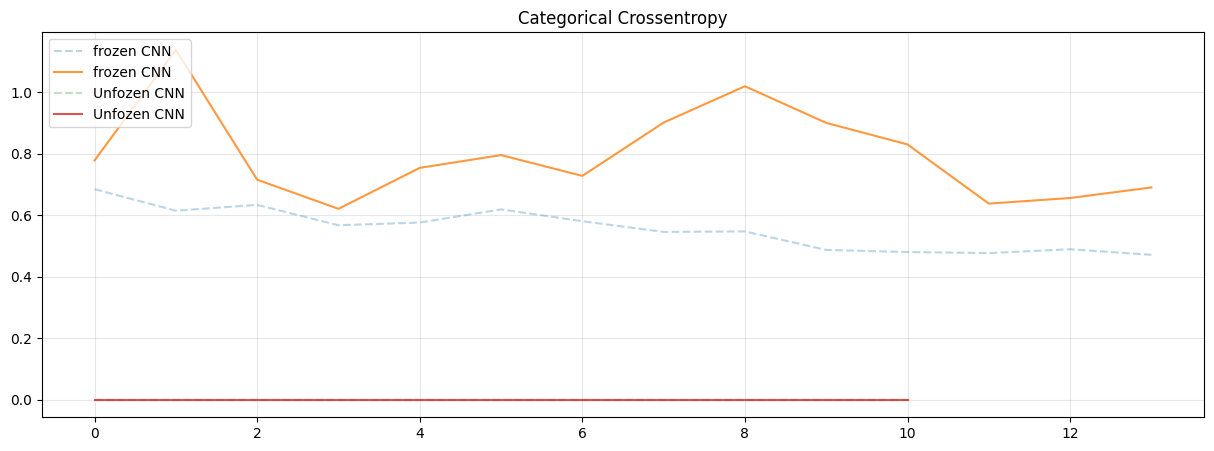

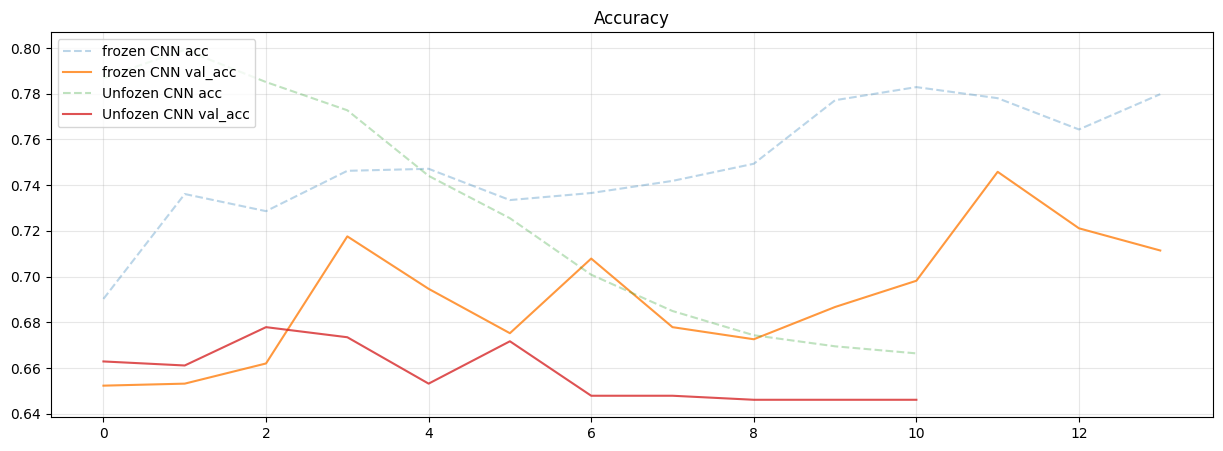

In [ ]:
# Plot the training
plt.figure(figsize=(15, 5))
plt.plot(hist["loss"], alpha=0.3, label="frozen CNN", linestyle="--")
plt.plot(hist["val_loss"], label="frozen CNN", alpha=0.8)
plt.plot(hist2["loss"], alpha=0.3, label="Unfozen CNN", linestyle="--")
plt.plot(hist2["val_loss"], label="Unfozen CNN", alpha=0.8)
plt.legend(loc="upper left")
plt.title("Categorical Crossentropy")
plt.grid(alpha=0.3)

plt.figure(figsize=(15, 5))
plt.plot(hist["accuracy"], alpha=0.3,label="frozen CNN acc", linestyle="--")
plt.plot(hist["val_accuracy"], label="frozen CNN val_acc", alpha=0.8)
plt.plot(hist2["accuracy"], alpha=0.3, label="Unfozen CNN acc", linestyle="--")
plt.plot(hist2["val_accuracy"], label="Unfozen CNN val_acc", alpha=0.8)
plt.legend(loc="upper left")
plt.title("Accuracy")
plt.grid(alpha=0.3)

plt.show()

## Test data

In [ ]:
import os
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

# Create a mapping from integer labels to string names
label_names = np.array(["healthy", "unhealthy"])  # Note: Corrected the array definition

# Create folder to store the images in Colab's local disk
root_dir = '/content/test'  # Use the '/content' directory in Colab
os.makedirs(root_dir, exist_ok=True)

# Get the total number of samples in the dataset
n_samples = len(X_test)

# Iterate through the dataset to save images
for i, (image, label) in enumerate(zip(X_test, y_test)):
    # Convert integer label to string name
    label_name = label_names[int(label)]

    # Create class directory if it doesn't exist
    class_dir = os.path.join(root_dir, label_name)
    os.makedirs(class_dir, exist_ok=True)

    # Define image path and save image
    image_path = os.path.join(class_dir, f'image_{i}.jpg')
    img = np.squeeze(image)  # Remove any singleton dimensions
    img = Image.fromarray(image.astype('uint8'))
    img.save(image_path)


In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    images = np.array(images)
    return images

In [ ]:
healthy_path = '/content/test/healthy/'
unhealthy_path = '/content/test/unhealthy/'

healthy_images = load_images_from_folder(healthy_path)
unhealthy_images = load_images_from_folder(unhealthy_path)

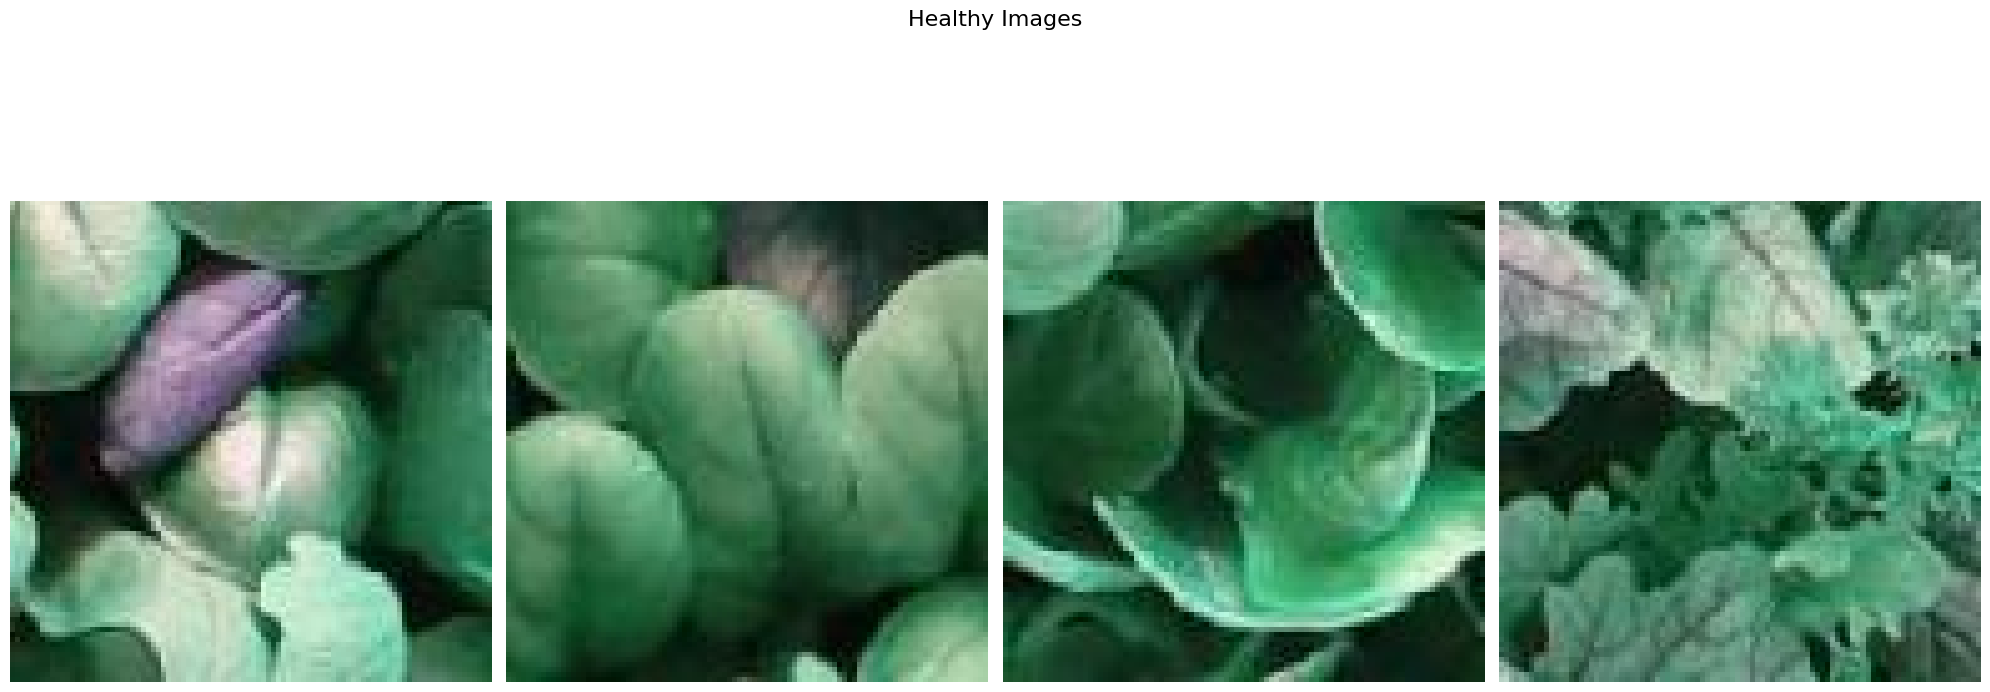

[326 518 554  33]


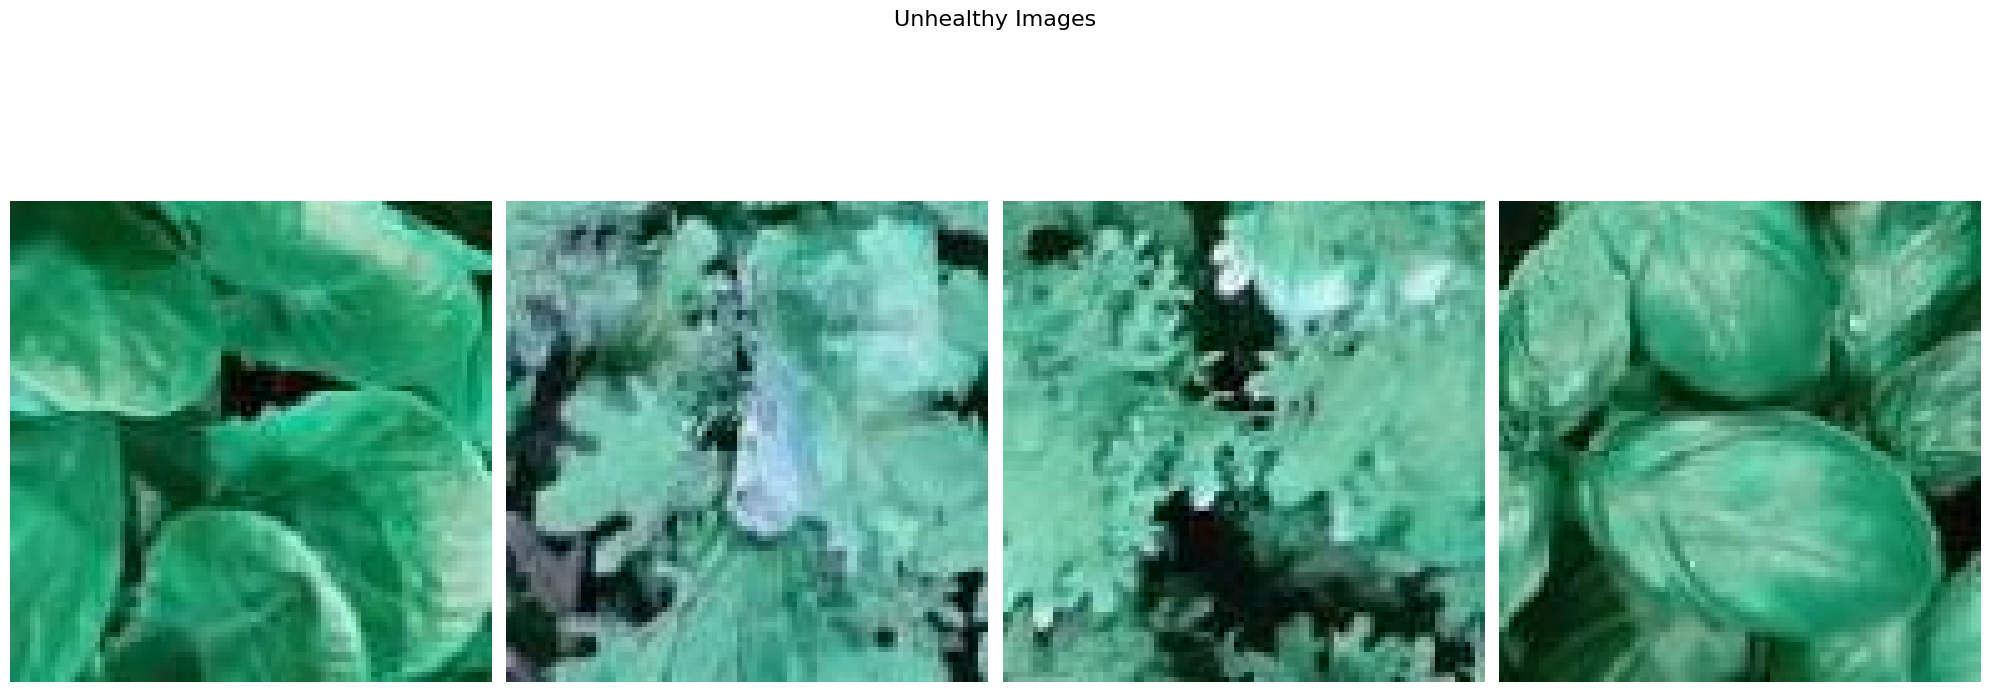

[369 224 321 155]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to display
num_img = 4

# Randomly select indices for healthy and unhealthy images
healthy_indices = np.random.choice(len(healthy_images), num_img, replace=False)
unhealthy_indices = np.random.choice(len(unhealthy_images), num_img, replace=False)

# Create subplots for displaying healthy_images
fig, axes = plt.subplots(1, num_img, figsize=(20, 9))
axes = axes.flatten()
for i in range(num_img):
    ax = axes[i]
    idx = healthy_indices[i]
    ax.imshow(np.clip(healthy_images[idx], 0, 255))  # Display clipped healthy images
    ax.axis("off")
plt.tight_layout()
plt.suptitle("Healthy Images", fontsize=16)  # Use plt.suptitle for the main title
plt.show()
print(healthy_indices)

# Create subplots for displaying unhealthy_images
fig, axes = plt.subplots(1, num_img, figsize=(20, 9))
axes = axes.flatten()
for i in range(num_img):
    ax = axes[i]
    idx = unhealthy_indices[i]
    ax.imshow(
        np.clip(unhealthy_images[idx], 0, 255)
    )  # Display clipped unhealthy images
    ax.axis("off")
plt.tight_layout()
plt.suptitle("Unhealthy Images", fontsize=16)  # Use plt.suptitle for the main title
plt.show()
print(unhealthy_indices)

### Test prediction

In [ ]:
# predict the test image
prediction = model.predict(proc_input([healthy_images[119]]), verbose=0)
# prediction = model.predict(proc_input([unhealthy_images[86]]), verbose=0)


if prediction >= 0.5:
    label = 'unhealthy'

else:
    label = 'healthy'

print(label)
print(prediction)

healthy
[[1.5396936e-15]]


### Confusion matrix

Accuracy: 0.6434
Precision: 0.75
Recall: 0.0147
F1: 0.0288


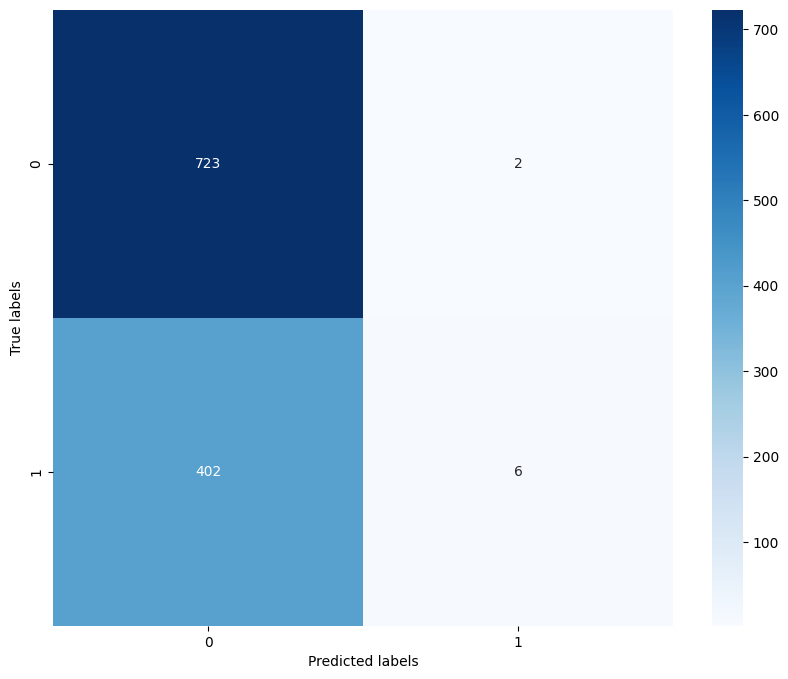

In [ ]:
def proc_input(X_input):
    X_input = tfkl.Resizing(IMG_SIZE, IMG_SIZE)(X_input)
    X_input = tf.cast(X_input, tf.float32)
    X_input = tf.keras.applications.densenet.preprocess_input(X_input)
    return X_input

X_test = proc_input(X_test)
predictions = model.predict(X_test, verbose=0)
# Define your labels (0 and 1 in this case)
labels = [0, 1]

# Assuming 'predictions' is an array of probabilities (sigmoid output)
# If 'predictions' contains probabilities, convert them to binary predictions using a threshold of 0.5
binary_predictions = (predictions > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, binary_predictions)

# Compute classification metrics
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [ ]:
binary_predictions = (predictions > 0.5).astype(int)
binary_predictions

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])